In [29]:
import torch
from torch import nn

In [30]:
# #code to free up gpu
# !pip install GPUtil

# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()         

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# all these numbers and layers are defined in alexnet implementation
alexnet = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 386, kernel_size=3, padding=1),nn.ReLU(),
            nn.Conv2d(386, 386, kernel_size=3, padding=1),nn.ReLU(),
            nn.Conv2d(386, 256, kernel_size=3, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),nn.Flatten(),
            
            # best way to get this 6400 is after adding flatten just check for the size of tensor returned after flatten layer
            nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
)

In [33]:
X =  torch.randn(1,1,224,224)
X.shape

torch.Size([1, 1, 224, 224])

In [34]:
alexnet(X).detach()

tensor([[-0.0083, -0.0040, -0.0112, -0.0066, -0.0162, -0.0061,  0.0029,  0.0082,
         -0.0006, -0.0167]])

In [35]:
# lets look at each layer

def look_at_net(net, X):
    
    for layer in net:
        X = layer(X)
        print(f' For {layer.__class__.__name__}, shape : {X.shape}')

In [36]:
look_at_net(alexnet, X)

 For Conv2d, shape : torch.Size([1, 96, 54, 54])
 For ReLU, shape : torch.Size([1, 96, 54, 54])
 For MaxPool2d, shape : torch.Size([1, 96, 26, 26])
 For Conv2d, shape : torch.Size([1, 256, 26, 26])
 For MaxPool2d, shape : torch.Size([1, 256, 12, 12])
 For Conv2d, shape : torch.Size([1, 386, 12, 12])
 For ReLU, shape : torch.Size([1, 386, 12, 12])
 For Conv2d, shape : torch.Size([1, 386, 12, 12])
 For ReLU, shape : torch.Size([1, 386, 12, 12])
 For Conv2d, shape : torch.Size([1, 256, 12, 12])
 For ReLU, shape : torch.Size([1, 256, 12, 12])
 For MaxPool2d, shape : torch.Size([1, 256, 5, 5])
 For Flatten, shape : torch.Size([1, 6400])
 For Linear, shape : torch.Size([1, 4096])
 For ReLU, shape : torch.Size([1, 4096])
 For Dropout, shape : torch.Size([1, 4096])
 For Linear, shape : torch.Size([1, 4096])
 For ReLU, shape : torch.Size([1, 4096])
 For Dropout, shape : torch.Size([1, 4096])
 For Linear, shape : torch.Size([1, 10])


In [37]:
# lets get the fashionmnist dataset

from torch.utils.data import Dataset, DataLoader

In [38]:
import pandas as pd
import torchvision.transforms as transforms

df = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv").head()

In [39]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

X.shape, y.shape

((5, 784), (5,))

In [40]:
X.iloc[0], y.iloc[0]

(pixel1      0
 pixel2      0
 pixel3      0
 pixel4      0
 pixel5      0
            ..
 pixel780    0
 pixel781    0
 pixel782    0
 pixel783    0
 pixel784    0
 Name: 0, Length: 784, dtype: int64,
 2)

In [41]:
# lets implement some helper functions for training this network



my_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
])

class fashion_dataset(Dataset):
    def __init__(self,data_path="../input/fashionmnist/fashion-mnist_train.csv", transforms=my_transforms, subset_length=2000):
        if subset_length:
            self.input_df = pd.read_csv(data_path)[:subset_length]
        else :
            self.input_df = pd.read_csv(data_path)
        self.len = len(self.input_df)
        self.transform = transforms

        self.x  = torch.from_numpy(self.input_df.iloc[:,1:].values)
        self.x = self.x.reshape(self.x.size(0), 1, 28,28).float()
        
        self.y = torch.from_numpy(self.input_df.iloc[:,0].values).long()
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        x_item = self.x[index]
        y_item = self.y[index]
        
        if (self.transform):
            x_item = self.transform(x_item)
               
        return x_item, y_item  
        

In [42]:
train_dataset = fashion_dataset()

In [43]:
train_dataset.__len__()

2000

torch.Size([1, 224, 224]) tensor(2)
tensor(2)


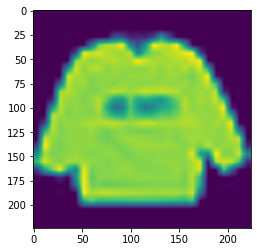

In [44]:
X, y = train_dataset[0]

print(X.shape, y)

import matplotlib.pyplot as plt

print(y)

img = X.permute(1,2,0)
plt.imshow(img)

In [45]:
test_dataset = fashion_dataset(data_path="../input/fashionmnist/fashion-mnist_test.csv")

In [46]:
batch_size=224
train_dataloader = DataLoader(train_dataset, batch_size=128,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=128, shuffle=False)

In [47]:
# helper function to make training easy

def accuracy(y_hat,y):
    return (y_hat.argmax(1)==y).sum()

In [48]:
def full_accuracy(net, data_iter):
    net.eval()
#     device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'
    net = net.to(device)
    
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)

            total_acc += accuracy(y_hat, y)
            total_num += y.numel()
    
    return total_acc/total_num
            

In [49]:
def train_net(net, train_dataloader, test_dataloader, lr, num_apochs=10):
    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f'training on {device}')
    net.train()
    
    net.to(device)
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    train_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        acc_value = 0
        total_number = 0
        total_loss= 0
        for X,y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            
            y_hat = net(X)
            l = loss(y_hat, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            total_loss += l 
            acc_value += accuracy(y_hat, y)
            total_number += y.numel()
            
#             print(l * X.shape[0], y.numel())
        
        with torch.no_grad():
            
            print(f"\tEpoch {epoch} : Statistics: ")
            print(f'\tcurrent train loss : {float(total_loss/total_number)}')
            print(f'\tcurrent train acc : {float(acc_value/total_number)}')
            print(f'\tcurrent test acc : {float(full_accuracy(net, test_dataloader))}')
    
            
            train_loss.append(float(total_loss/total_number))
            test_acc.append(float(full_accuracy(net, test_dataloader)))
            train_acc.append(float(acc_value/total_number))
    
#     plt.plot(range(num_epochs), train_loss, label = 'train loss')
    plt.plot(range(num_epochs), train_acc, label = 'train acc')
    plt.plot(range(num_epochs), test_acc, label = 'test acc')
    plt.grid(True)
    plt.legend()
    plt.show()
            
        

In [50]:
# %%time
# lr , num_epochs = 0.5, 10
# train_net(alexnet, train_dataloader, test_dataloader, num_epochs, lr)

# Problems and approach

1. Alexnet is too complex it takes more than 64 gb of space
2. So I tried training only 2000 images instead.

3. lets trying simplyfyingalex net


In [51]:
# all these numbers and layers are defined in alexnet implementation
alexnet_new = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),nn.Flatten(),
            
            # best way to get this 6400 is after adding flatten just check for the size of tensor returned after flatten layer
            nn.Linear(384, 120), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(120, 10)
)

In [52]:
X = torch.randn(1,1,28,28)

In [53]:
look_at_net(alexnet_new, X)

 For Conv2d, shape : torch.Size([1, 96, 5, 5])
 For ReLU, shape : torch.Size([1, 96, 5, 5])
 For MaxPool2d, shape : torch.Size([1, 96, 2, 2])
 For Flatten, shape : torch.Size([1, 384])
 For Linear, shape : torch.Size([1, 120])
 For ReLU, shape : torch.Size([1, 120])
 For Dropout, shape : torch.Size([1, 120])
 For Linear, shape : torch.Size([1, 10])


In [54]:
train_dataset = fashion_dataset(transforms=None)
test_dataset = fashion_dataset(data_path="../input/fashionmnist/fashion-mnist_test.csv", transforms=None)
batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)

training on cpu
	Epoch 0 : Statistics: 
	current train loss : 13150819.0
	current train acc : 0.10350000113248825
	current test acc : 0.10100000351667404
	Epoch 1 : Statistics: 
	current train loss : 1.3403031826019287
	current train acc : 0.0989999994635582
	current test acc : 0.10000000149011612
	Epoch 2 : Statistics: 
	current train loss : 0.0636177808046341
	current train acc : 0.1054999977350235
	current test acc : 0.1014999970793724
	Epoch 3 : Statistics: 
	current train loss : 0.035737037658691406
	current train acc : 0.09799999743700027
	current test acc : 0.10100000351667404
	Epoch 4 : Statistics: 
	current train loss : 0.02229144051671028
	current train acc : 0.09099999815225601
	current test acc : 0.09549999982118607
	Epoch 5 : Statistics: 
	current train loss : 0.019999120384454727
	current train acc : 0.08150000125169754
	current test acc : 0.10100000351667404
	Epoch 6 : Statistics: 
	current train loss : 0.019534535706043243
	current train acc : 0.10849999636411667
	curre

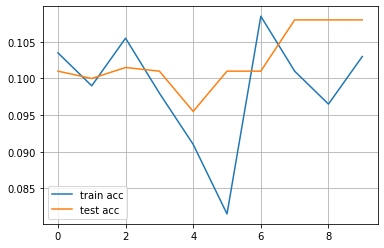

CPU times: user 6.58 s, sys: 79.8 ms, total: 6.66 s
Wall time: 3.38 s


In [55]:
%%time
lr , num_epochs = 0.5, 10
train_net(alexnet_new, train_dataloader, test_dataloader, num_epochs, lr)

it is definitely training faster but very innacurate.

## Exercises
1. Try increasing the number of epochs. Compared with LeNet, how are the results different? Why?

* The result is a very noisy function, it is like its not getting trained at all.

2. AlexNet may be too complex for the Fashion-MNIST dataset.
    1. Try simplifying the model to make the training faster, while ensuring that the accuracy
    does not drop significantly.

    * done but accuracy has still not improved.

    2. Design a better model that works directly on 28 × 28 images.

    * done. 

3. Modify the batch size, and observe the changes in accuracy and GPU memory.

* more batch size more consumption

4. Analyze computational performance of AlexNet.

    1. What is the dominant part for the memory footprint of AlexNet?
        * Linear network and 3 cnns
    2. What is the dominant part for computation in AlexNet?
        * the neuralnetwork 3 cnns
    3. How about memory bandwidth when computing the results?
        * more than 100 mb
5. Apply dropout and ReLU to LeNet-5. Does it improve? How about preprocessing?
   ```python
    
    lenet_5 = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.ReLU(), nn.Dropout(p=0.5),
                    nn.Linear(120, 84), nn.ReLU(), nn.Linear(84, 10))
   ```

training on cpu
	Epoch 0 : Statistics: 
	current train loss : 1.0561742782592773
	current train acc : 0.09849999845027924
	current test acc : 0.10249999910593033
	Epoch 1 : Statistics: 
	current train loss : 0.5421227812767029
	current train acc : 0.09549999982118607
	current test acc : 0.09449999779462814
	Epoch 2 : Statistics: 
	current train loss : 0.5225846767425537
	current train acc : 0.10300000011920929
	current test acc : 0.10249999910593033
	Epoch 3 : Statistics: 
	current train loss : 0.3329907953739166
	current train acc : 0.09149999916553497
	current test acc : 0.09399999678134918
	Epoch 4 : Statistics: 
	current train loss : 0.3723755180835724
	current train acc : 0.10249999910593033
	current test acc : 0.10000000149011612
	Epoch 5 : Statistics: 
	current train loss : 0.5006359815597534
	current train acc : 0.10750000178813934
	current test acc : 0.10199999809265137
	Epoch 6 : Statistics: 
	current train loss : 0.3336432874202728
	current train acc : 0.09149999916553497
	c

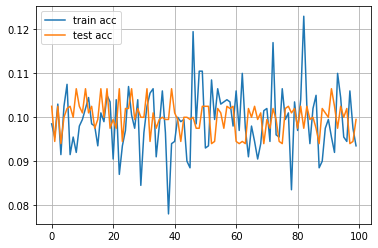

CPU times: user 1min 9s, sys: 595 ms, total: 1min 9s
Wall time: 34.8 s


In [56]:

%%time
lr , num_epochs = 0.5, 100
train_net(alexnet_new, train_dataloader, test_dataloader, num_epochs, lr)

In [60]:
# 5

lenet_5 = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.ReLU(), nn.Dropout(p=0.5),
                    nn.Linear(120, 84), nn.ReLU(), nn.Linear(84, 10))

training on cpu
	Epoch 0 : Statistics: 
	current train loss : 0.07263289391994476
	current train acc : 0.10100000351667404
	current test acc : 0.10100000351667404
	Epoch 1 : Statistics: 
	current train loss : 0.036422181874513626
	current train acc : 0.09700000286102295
	current test acc : 0.10100000351667404
	Epoch 2 : Statistics: 
	current train loss : 0.022028813138604164
	current train acc : 0.10199999809265137
	current test acc : 0.10249999910593033
	Epoch 3 : Statistics: 
	current train loss : 0.019664421677589417
	current train acc : 0.08150000125169754
	current test acc : 0.10249999910593033
	Epoch 4 : Statistics: 
	current train loss : 0.01916610263288021
	current train acc : 0.10050000250339508
	current test acc : 0.10249999910593033
	Epoch 5 : Statistics: 
	current train loss : 0.02018781192600727
	current train acc : 0.10999999940395355
	current test acc : 0.09749999642372131
	Epoch 6 : Statistics: 
	current train loss : 0.021140916272997856
	current train acc : 0.093999996

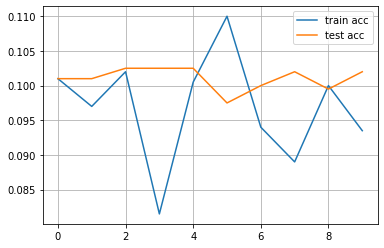

CPU times: user 6.85 s, sys: 57.7 ms, total: 6.91 s
Wall time: 3.51 s


In [61]:

%%time
lr , num_epochs = 0.5, 10
train_net(alexnet_new, train_dataloader, test_dataloader, num_epochs, lr)